In [13]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import scipy.signal as signal
import cf_xarray as cfxr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data and calculate GF

In [14]:
model_run_1pct_dict = utils.model_run_1pct_dict
model_run_control_dict = utils.model_run_picontrol_dict


In [15]:
fg_co2_1pct = {}
fg_co2_pictrl = {}
nbp_1pct = {}
nbp_pictrl = {}
co2_1pct = {}
co2_pictrl = {}
areacello = {}
areacella = {}

In [16]:
for m in model_run_1pct_dict.keys():
    print(m)
    print('load 1pct run')
    print('fgco2')
    fg_co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_1pct_dict[m]}', use_cftime=True) #kgC/m2/s
#     if 'vertices_latitude' in list(fg_co2_1pct[m].keys()):
#         fg_co2_1pct[m] = fg_co2_1pct[m].rename({'vertices_latitude':'lat_bnds'})
#     if 'vertices_longitude' in list(fg_co2_1pct[m].keys()):
#         fg_co2_1pct[m] = fg_co2_1pct[m].rename({'vertices_longitude':'lon_bnds'}) 
#     if 'vertices' in list(fg_co2_1pct[m].dims):
#         fg_co2_1pct[m] = fg_co2_1pct[m].drop_dims('bnds')
#         fg_co2_1pct[m] = fg_co2_1pct[m].rename({'vertices':'bnds'})
#     lat_corners = cfxr.bounds_to_vertices(fg_co2_1pct[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
#     lon_corners = cfxr.bounds_to_vertices(fg_co2_1pct[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
#     fg_co2_1pct[m] = fg_co2_1pct[m].assign(lon_b=lon_corners, lat_b=lat_corners)
#     fg_co2_1pct[m] = utils._regrid_ds(fg_co2_1pct[m], ds_out)
    
    
    print('nbp')
    nbp_1pct[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_1pct_dict[m]}', use_cftime=True) #kgC/m2/s
#     lat_corners = cfxr.bounds_to_vertices(nbp_1pct[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
#     lon_corners = cfxr.bounds_to_vertices(nbp_1pct[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
#     nbp_1pct[m] = nbp_1pct[m].assign(lon_b=lon_corners, lat_b=lat_corners)
#     nbp_1pct[m] = utils._regrid_ds(nbp_1pct[m], ds_out)
    if m == 'UKESM1_r1' or m == 'UKESM1_r2' or m == 'UKESM1_r3' or m == 'UKESM1_r4' or m == 'NORESM2' or m == 'GFDL':
        #print('co2mass')
        co2_1pct[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_1pct_dict[m]}', use_cftime=True) #kg
    
    

UKESM1_r1
load 1pct run
fgco2
nbp
UKESM1_r2
load 1pct run
fgco2
nbp
UKESM1_r3
load 1pct run
fgco2
nbp
UKESM1_r4
load 1pct run
fgco2
nbp
MIROC
load 1pct run
fgco2
nbp
NORESM2
load 1pct run
fgco2
nbp
ACCESS
load 1pct run
fgco2
nbp
GFDL
load 1pct run
fgco2
nbp
CANESM5_r1p2
load 1pct run
fgco2
nbp
CANESM5_r2p2
load 1pct run
fgco2
nbp
CANESM5_r3p2
load 1pct run
fgco2
nbp
CANESM5_r1p1
load 1pct run
fgco2
nbp
CANESM5_r2p1
load 1pct run
fgco2
nbp
CANESM5_r3p1
load 1pct run
fgco2
nbp


In [17]:
for m in model_run_control_dict.keys():
    print(m)
    print('load pi control run')
    fg_co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/fgco2_Omon_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4') #kg/m2/s 
#     if 'vertices_latitude' in list(fg_co2_pictrl[m].keys()):
#         fg_co2_pictrl[m] = fg_co2_pictrl[m].rename({'vertices_latitude':'lat_bnds'})
#     if 'vertices_longitude' in list(fg_co2_pictrl[m].keys()):
#         fg_co2_pictrl[m] = fg_co2_pictrl[m].rename({'vertices_longitude':'lon_bnds'}) 
#     if 'vertices' in list(fg_co2_pictrl[m].dims):
#         fg_co2_pictrl[m] = fg_co2_pictrl[m].drop_dims('bnds')
#         fg_co2_pictrl[m] = fg_co2_pictrl[m].rename({'vertices':'bnds'})
#     lat_corners = cfxr.bounds_to_vertices(fg_co2_pictrl[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
#     lon_corners = cfxr.bounds_to_vertices(fg_co2_pictrl[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
#     fg_co2_pictrl[m] = fg_co2_pictrl[m].assign(lon_b=lon_corners, lat_b=lat_corners)
#     fg_co2_pictrl[m] = utils._regrid_ds(fg_co2_pictrl[m], ds_out)

    
    nbp_pictrl[m] = xr.open_mfdataset(f'cmip6_data/nbp_Lmon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kgC/m2/s 
#     lat_corners = cfxr.bounds_to_vertices(nbp_pictrl[m].isel(time = 0)['lat_bnds'], "bnds", order=None)
#     lon_corners = cfxr.bounds_to_vertices(nbp_pictrl[m].isel(time = 0)['lon_bnds'], "bnds", order=None)
#     nbp_pictrl[m] = nbp_pictrl[m].assign(lon_b=lon_corners, lat_b=lat_corners)
#     nbp_pictrl[m] = utils._regrid_ds(nbp_pictrl[m], ds_out)

    if m == 'UKESM1_r1' or m == 'NORESM2' or m == 'GFDL':
        co2_pictrl[m] = xr.open_mfdataset(f'cmip6_data/co2mass_Amon_{model_run_control_dict[m]}',use_cftime=True, engine = 'netcdf4') #kg
    
    areacello[m] = xr.open_mfdataset(f'cmip6_data/areacello_Ofx_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4')
    areacella[m] = xr.open_mfdataset(f'cmip6_data/areacella_fx_{model_run_control_dict[m]}', use_cftime=True, engine = 'netcdf4')


UKESM1_r1
load pi control run
MIROC
load pi control run
NORESM2
load pi control run
ACCESS
load pi control run
GFDL
load pi control run
CANESM5_r1p2
load pi control run
CANESM5_r1p1
load pi control run


### Notes:

GFDL: 1pct and esm pi-control start from year 0001

UKESM1: 1pct starts in 1850 and pi-control starts in 1960, move 1pct to start in 1960

MIROC: both start from 1850

NORESM2: 1pct from 0001 pi-control from 1600-- move 1pct to 1600

ACCESS: 1pct and pi-control from 0101

CANESM5_r1p2: 1pct 1850, pi-control 5550, move 1pct to 5550


In [18]:
kgCO2_to_kgC = 1/3.67

#convert kg to kg/year
for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4', 'NORESM2', 'GFDL']:
    seconds_per_yr = 60*60*24*365
    co2_1pct[m]['G_atm'] = co2_1pct[m]['co2mass'].diff('time')/(co2_1pct[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr
    co2_1pct[m]['G_atm'] *= kgCO2_to_kgC
    co2_1pct[m]['G_atm'].attrs = {'units':'kgC'}
    
for m in [ 'NORESM2', 'GFDL', 'UKESM1_r1']:
    seconds_per_yr = 60*60*24*365
    co2_pictrl[m]['G_atm'] = co2_pictrl[m]['co2mass'].diff('time')/(co2_pictrl[m]['time'].diff('time').astype('float64')/(1e9*seconds_per_yr)) #convert from ns to year via 1e9ns/s x 60s/min x 60min/hr x 24hr/day x 365day/yr
    co2_pictrl[m]['G_atm'] *= kgCO2_to_kgC
    co2_pictrl[m]['G_atm'].attrs = {'units':'kgC'}

In [19]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [20]:
## fix the times so that they line up according to the notes above
m = 'NORESM2'
nbp_1pct[m]['time'] = nbp_pictrl[m]['time'][:len(nbp_1pct[m]['time'])]
fg_co2_1pct[m]['time'] = fg_co2_pictrl[m]['time'][:len(fg_co2_1pct[m]['time'])]
co2_1pct[m]['time'] = co2_pictrl[m]['time'][:len(co2_1pct[m]['time'])]
co2_1pct[m] *=1.5172413793 #currently saved as the vmr (see the attributes, has not been properly converted)
co2_pictrl[m] *=1.5172413793 #currently saved as the vmr (see the attributes, has not been properly converted)


for m in ['UKESM1_r1', 'UKESM1_r2', 'UKESM1_r3', 'UKESM1_r4']:
    nbp_1pct[m]['time'] = nbp_pictrl['UKESM1_r1']['time'][:len(nbp_1pct[m]['time'])]
    fg_co2_1pct[m]['time'] = fg_co2_pictrl['UKESM1_r1']['time'][:len(fg_co2_1pct[m]['time'])]
    co2_1pct[m]['time'] = co2_pictrl['UKESM1_r1']['time'][:len(co2_1pct[m]['time'])]

for m in ['CANESM5_r1p2', 'CANESM5_r2p2', 'CANESM5_r3p2']:
    nbp_1pct[m]['time'] = nbp_pictrl['CANESM5_r1p2']['time'][:len(nbp_1pct[m]['time'])]
    fg_co2_1pct[m]['time'] = fg_co2_pictrl['CANESM5_r1p2']['time'][:len(fg_co2_1pct[m]['time'])]

for m in [ 'CANESM5_r1p1', 'CANESM5_r2p1', 'CANESM5_r3p1']:
    nbp_1pct[m]['time'] = nbp_pictrl['CANESM5_r1p1']['time'][:len(nbp_1pct[m]['time'])]
    fg_co2_1pct[m]['time'] = fg_co2_pictrl['CANESM5_r1p1']['time'][:len(fg_co2_1pct[m]['time'])]
    

In [21]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)
A = utils.find_area(ds_out, R = 6.3781e6)

#replace GFDL areacello with this-- areacello doesn't match up

areacello['GFDL'] = A

In [22]:
fg_co2 = {}
nbp = {}

for m1 in model_run_1pct_dict.keys():
    print(m1)
    if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
        m2 = 'UKESM1_r1'
    elif m1 == 'CANESM5_r1p1' or m1 == 'CANESM5_r2p1' or m1 == 'CANESM5_r3p1':
         m2 = 'CANESM5_r1p1'
    elif m1 == 'CANESM5_r1p2' or m1 == 'CANESM5_r2p2' or m1 == 'CANESM5_r3p2':
         m2 = 'CANESM5_r1p2'
    else:
        m2 = m1
    print(m1, m2)
    fg_co2[m1] = fg_co2_1pct[m1] - fg_co2_pictrl[m2]
    nbp[m1] = nbp_1pct[m1] - nbp_pictrl[m2]
    
    if m2 == 'GFDL':
        fg_co2[m1]['fgco2'] = fg_co2[m1]['fgco2']*seconds_per_yr*areacello[m2]
    else:
        fg_co2[m1]['fgco2'] = fg_co2[m1]['fgco2']*seconds_per_yr*areacello[m2]['areacello']
    nbp[m1]['nbp'] = nbp[m1]['nbp']*seconds_per_yr*areacella[m2]['areacella']

UKESM1_r1
UKESM1_r1 UKESM1_r1
UKESM1_r2
UKESM1_r2 UKESM1_r1
UKESM1_r3
UKESM1_r3 UKESM1_r1
UKESM1_r4
UKESM1_r4 UKESM1_r1
MIROC
MIROC MIROC
NORESM2
NORESM2 NORESM2
ACCESS
ACCESS ACCESS
GFDL
GFDL GFDL
CANESM5_r1p2
CANESM5_r1p2 CANESM5_r1p2
CANESM5_r2p2
CANESM5_r2p2 CANESM5_r1p2
CANESM5_r3p2
CANESM5_r3p2 CANESM5_r1p2
CANESM5_r1p1
CANESM5_r1p1 CANESM5_r1p1
CANESM5_r2p1
CANESM5_r2p1 CANESM5_r1p1
CANESM5_r3p1
CANESM5_r3p1 CANESM5_r1p1


In [23]:
co2_dif = {}
for m1 in co2_1pct.keys():
    if m1 == 'UKESM1_r1' or m1 == 'UKESM1_r2' or m1 == 'UKESM1_r3' or m1 == 'UKESM1_r4':
        m2 = 'UKESM1_r1'
    else:
        m2 = m1
    print(m1, m2)
    co2_dif[m1] = co2_1pct[m1]['G_atm'] - co2_pictrl[m2]['G_atm'] #kg/yr

UKESM1_r1 UKESM1_r1
UKESM1_r2 UKESM1_r1
UKESM1_r3 UKESM1_r1
UKESM1_r4 UKESM1_r1
NORESM2 NORESM2
GFDL GFDL


ValueError: 'j' not found in array dimensions ('time', 'y', 'x')

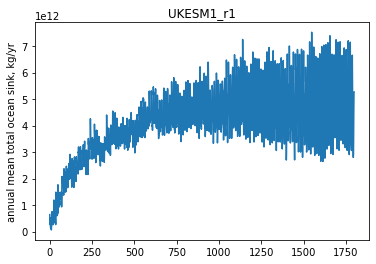

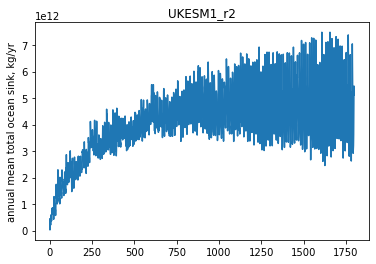

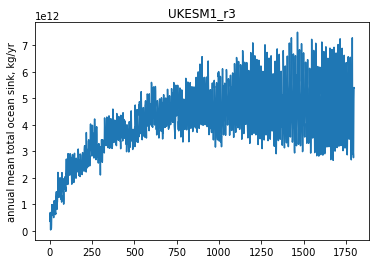

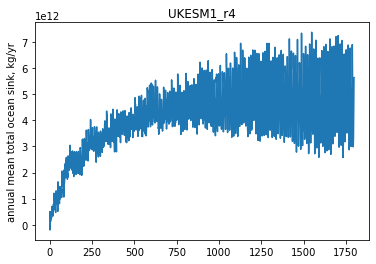

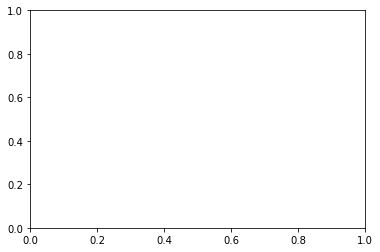

In [12]:
for m in fg_co2.keys():
    fig, ax = plt.subplots()
    plt.plot(fg_co2[m]['fgco2'].sum(dim = ['j','i']))
    plt.ylabel('annual mean total ocean sink, kg/yr')
    plt.title(m)

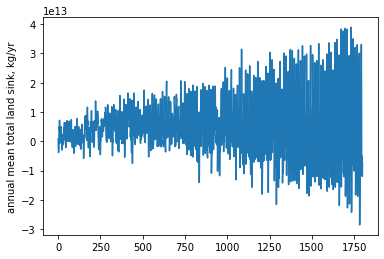

In [27]:
for m in nbp.keys():
    fig, ax = plt.subplots()
    plt.plot(nbp[m]['nbp'].sum(dim = ['lat','lon']))
    plt.ylabel('annual mean total land sink, kg/yr')

In [24]:
#total sinks
emis_sinks = {}
for m in nbp.keys():
    if 'lat' in list(fg_co2[m]['fgco2'].dims):
        emis_sinks[m] = nbp[m]['nbp'].sum(dim = ['lat','lon']) + fg_co2[m]['fgco2'].sum(dim = ['lat','lon'])
    elif 'i' in list(fg_co2[m]['fgco2'].dims):
        emis_sinks[m] = nbp[m]['nbp'].sum(dim = ['lat','lon']) + fg_co2[m]['fgco2'].sum(dim = ['i','j'])
    elif 'x' in list(fg_co2[m]['fgco2'].dims):
        emis_sinks[m] = nbp[m]['nbp'].sum(dim = ['lat','lon']) + fg_co2[m]['fgco2'].sum(dim = ['x','y'])

In [27]:
#fix the times to all be the same, weight by month and take the mean

for m in nbp.keys():
    times = pd.date_range('2000', periods=len(emis_sinks[m]['time']), freq='MS')
    weights = times.shift(1, 'MS') - times
    weights = xr.DataArray(weights, [('time', emis_sinks[m]['time'].values)]).astype('float')
    emis_sinks[m] =  (emis_sinks[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')


In [ ]:
for m in emis_sinks.keys():
    fig, ax = plt.subplots()
    plt.plot(emis_sinks[m])
    plt.ylabel('total kg/yr lost to ocean and land')

In [28]:
G_atm = {}
for m in co2_dif.keys():

    times = pd.date_range('2000', periods=len(co2_dif[m]['time']), freq='MS')
    weights = times.shift(1, 'MS') - times
    weights = xr.DataArray(weights, [('time', co2_dif[m]['time'].values)]).astype('float')

    G_atm[m] = (co2_dif[m] * weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')


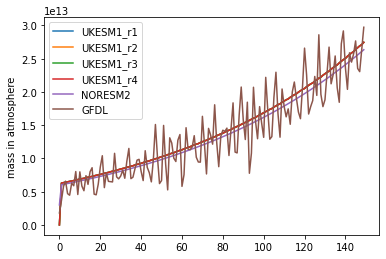

In [18]:
fig, ax = plt.subplots()
for m in G_atm.keys():
    plt.plot(G_atm[m], label = m)
    plt.ylabel('mass in atmosphere')
    plt.legend()

In [29]:
for m in emis_sinks.keys():
    emis_sinks[m]['year'] = np.arange(0, len(emis_sinks[m]['year']))

In [30]:
for m in G_atm.keys():
    G_atm[m]['year'] = np.arange(0, len(G_atm[m]['year']))

In [31]:
def diff_lists(list1, list2):
    return list(set(list1).symmetric_difference(set(list2)))  # or return list(set(list1) ^ set(list2))

emis_co2 = {}
for m in G_atm.keys():
        emis_co2[m] = G_atm[m] + emis_sinks[m]

for m in diff_lists(emis_sinks.keys(), G_atm.keys()):
        emis_co2[m] = G_atm['UKESM1_r1'] + emis_sinks[m] #use UKESM1_r1 co2 mass bc these runs don't have their own
    

In [32]:
emis_co2_GtC = {}
kg_to_Gt = 1e-12

for m in emis_co2.keys():
    emis_co2_GtC[m] = emis_co2[m]*kg_to_Gt
    

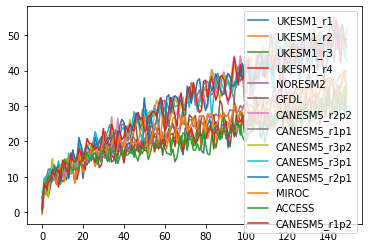

In [23]:
fig, ax = plt.subplots()
for m in emis_co2_GtC.keys():
    plt.plot(emis_co2_GtC[m], label = m) #Gt/yr

    plt.legend()

In [33]:
emis_co2_GtC_ds = xr.concat([emis_co2_GtC[m] for m in emis_co2_GtC.keys()], pd.Index([m for m in emis_co2_GtC.keys()], name='model'), coords='minimal')

In [34]:
emis_co2_GtC_ds

<xarray.DataArray (model: 14, year: 150)>
dask.array<concatenate, shape=(14, 150), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 0 1 2 3 4 5 6 7 8 ... 142 143 144 145 146 147 148 149
    depth    float64 0.0
  * model    (model) object 'UKESM1_r1' 'UKESM1_r2' ... 'CANESM5_r1p2'

In [ ]:
for m in emis_co2_GtC_ds.model.values:
    plt.plot(emis_co2_GtC_ds.sel(model = m), label = m)
    plt.legend()

# Save out CO2 emissions

In [35]:
emis_co2_GtC_ds.to_netcdf('1pct_emis_profile_full.nc4')
